<a href="https://colab.research.google.com/github/CourantEnCourant/rag_course/blob/main/BERT_T5_classifier_LoRA_PEFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install tensorboard
!pip install sentencepiece
!pip install accelerate
!pip install evaluate
!pip install py7zr

In [ ]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
from torch.utils.data import DataLoader, TensorDataset
import random

df = pd.read_csv('fr_yi_ru_corpus.csv')[:120]

# Conversion des labels en indices numériques
label_map = {"fr": 0, "yi": 1, "ru": 2}
df["label"] = df["langue"].map(label_map)

# Division train/test
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Créer une classe pour le classificateur
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim, num_labels):
        super(SimpleClassifier, self).__init__()
        self.linear = nn.Linear(input_dim, num_labels) # Quelle est la taille de la couche linéaire?

    def forward(self, x):
        return self.linear(x)

# Fonction pour obtenir les embeddings [CLS]
def get_bert_embeddings(texts, model, tokenizer, device='cpu'):
    model.eval()  # Mode évaluation
    embeddings = []

    batch_size = 32
    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        # Tokenization
        encoded_input = # tokenisez et mettez le tenseur sur "device"

        # Extraire les embeddings sans calcul de gradient
        with torch.no_grad():
            outputs = # appelez le modèle

            batch_embeddings = # Utilisez la dernière couche cachée du [CLS] token (premier token de chaque séquence) et mettez le sur CPU
            embeddings.append(batch_embeddings)

    return np.vstack(embeddings)

# Implémenter l'inférence avec le classificateur
def predict_language_with_classifier(model, classifier, tokenizer, texts, label_map_inverse, device='cpu'):

    embeddings = get_bert_embeddings(texts, model, tokenizer, device)
    embeddings_tensor = torch.tensor(embeddings).to(device)

    classifier.eval()
    with torch.no_grad():
        logits = classifier(embeddings_tensor)
        predictions = torch.argmax(logits, dim=1).cpu().numpy()

    predicted_langs = [label_map_inverse[pred] for pred in predictions]
    return predicted_langs

# Usage pour l'inférence sans finetuning
def setup_and_test_inference():
    # Charger modèle et tokenizer
    tokenizer = # chargez le tokenizer 'bert-base-multilingual-cased'
    bert_model = # chargez le modèle 'bert-base-multilingual-cased'
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    bert_model.to(device)

    # Configuration du classificateur
    embedding_dim = bert_model.config.hidden_size  # taille?
    num_labels = len(label_map)  # taille?
    classifier = SimpleClassifier(embedding_dim, num_labels).to(device)

    # Création du mapping inverse pour les labels
    label_map_inverse = {v: k for k, v in label_map.items()}

    # --- Partie entraînement du classificateur ---
    # Extraire des embeddings pour les données d'entraînement
    train_embeddings = get_bert_embeddings(train_df["texte"].tolist(), bert_model, tokenizer, device)
    train_labels = torch.tensor(train_df["label"].tolist()).to(device)

    # Définir l'optimiseur et la fonction de perte
    optimizer = torch.optim.Adam(classifier.parameters(), lr=0.001)
    loss_function = nn.CrossEntropyLoss()

    # Entraîner le classificateur simple
    classifier.train()
    num_epochs = 5
    batch_size = 32

    for epoch in range(num_epochs):
        total_loss = 0
        for i in range(0, len(train_embeddings), batch_size):
            batch_embeddings = torch.tensor(train_embeddings[i:i+batch_size]).to(device)
            batch_labels = train_labels[i:i+batch_size]

            # Forward
            logits = classifier(batch_embeddings)
            loss = loss_function(logits, batch_labels)

            # Backward
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {total_loss/len(train_embeddings)*batch_size:.4f}")

    # Évaluer sur les données de test
    test_texts = test_df["texte"].tolist()
    true_labels = test_df["langue"].tolist()
    predicted_langs = predict_language_with_classifier(bert_model, classifier, tokenizer, test_texts, label_map_inverse, device)

    # Afficher les résultats
    accuracy = sum([pred == true for pred, true in zip(predicted_langs, true_labels)]) / len(true_labels)
    print(f"\nAccuracy: {accuracy:.4f}")
    print("\nExemples de prédictions:")
    for i in range(min(5, len(test_texts))):
        print(f"Texte: {test_texts[i]}")
        print(f"Langue réelle: {true_labels[i]}, Langue prédite: {predicted_langs[i]}\n")

    return bert_model, classifier, tokenizer

# Exécuter
bert_model, classifier, tokenizer = setup_and_test_inference()

In [ ]:
!wget "https://www.dropbox.com/scl/fi/525gv6tmdi3n32mipo6mr/input.zip?rlkey=5jdsxahphk2ped5wxbxnv0n4y&dl=1" -O input.zip

!unzip input.zip

In [ ]:
import torch

from transformers import (
    T5Tokenizer,
    T5ForConditionalGeneration,
    TrainingArguments,
    Trainer
)
from datasets import load_dataset

In [ ]:
MODEL = 't5-small'
BATCH_SIZE = 32
NUM_PROCS = 16
EPOCHS = 5
OUT_DIR = 'results_t5small'
MAX_LENGTH = 256

In [ ]:
dataset_train = load_dataset(
    'csv',
    data_files='input/train.csv',
    split='train'
)
dataset_valid = load_dataset(
    'csv',
    data_files='input/valid.csv',
    split='train'
)

In [ ]:
tokenizer = T5Tokenizer.from_pretrained(MODEL)

def preprocess_function(examples):
    inputs = [f"assign tag: {title} {body}" for (title, body) in zip(examples['Title'], examples['Body'])]
    model_inputs = tokenizer(
        inputs,
        max_length=MAX_LENGTH,
        truncation=True,
        padding='max_length'
    )

    cleaned_tag = [' '.join(''.join(tag.split('<')).split('>')[:-1]) for tag in examples['Tags']]
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            cleaned_tag,
            max_length=MAX_LENGTH,
            truncation=True,
            padding='max_length'
        )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [ ]:
tokenized_train = dataset_train.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)
tokenized_valid = dataset_valid.map(
    preprocess_function,
    batched=True,
    num_proc=NUM_PROCS
)

In [ ]:
model = T5ForConditionalGeneration.from_pretrained(MODEL)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"{total_params:,} total parameters.")
total_trainable_params = sum(
    p.numel() for p in model.parameters() if p.requires_grad)
print(f"{total_trainable_params:,} training parameters.")

In [ ]:
training_args = TrainingArguments(
    output_dir=OUT_DIR,
    num_train_epochs=EPOCHS,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir=OUT_DIR,
    logging_steps=10,
    evaluation_strategy='steps',
    save_steps=500,
    eval_steps=500,
    load_best_model_at_end=True,
    save_total_limit=5,
    report_to='tensorboard',
    learning_rate=0.0001,
    fp16=True,
    dataloader_num_workers=4
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
)


In [ ]:
history = trainer.train()

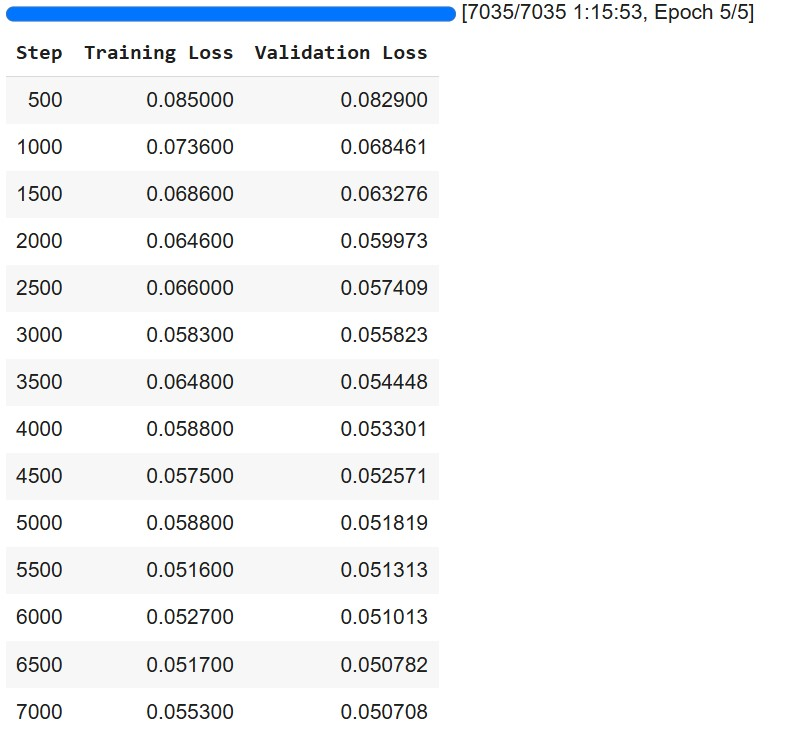

In [ ]:
tokenizer.save_pretrained(OUT_DIR)

In [ ]:
!wget "https://www.dropbox.com/scl/fi/9brsjizymq5zvqi7hff09/inference_data.zip?rlkey=ukmdy5egmdld80r5hhmsja78v&dl=1" -O inference_data.zip
!unzip inference_data.zip

In [ ]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import os

model_path = '/content/results_t5small/checkpoint-7035/'  # chemin vers votre modèle sauvegardé
model = T5ForConditionalGeneration.from_pretrained(model_path)
tokenizer = T5Tokenizer.from_pretrained('results_t5small')

In [ ]:
def do_correction(text, model, tokenizer):
    input_text = f"assign tag: {text}"
    inputs = tokenizer.encode(
        input_text,
        return_tensors='pt',
        max_length=256,
        padding='max_length',
        truncation=True
    )

    corrected_ids = model.generate(
        inputs,
        max_length=256,
        num_beams=5, # `num_beams=1` montre la temperature du sampling.
        early_stopping=True
    )

    corrected_sentence = tokenizer.decode(
        corrected_ids[0],
        skip_special_tokens=True
    )
    return corrected_sentence

In [ ]:
for file in os.listdir('inference_data/'):
    f = open(f"inference_data/{file}", 'r')
    sentence = f.read()
    corrected_sentence = do_correction(sentence, model, tokenizer)
    print(f"QUERY: {sentence}\nTAGS: {corrected_sentence}")
    print('-'*100)

In [ ]:
# Optimisation LORA + PEFT

from datasets import load_dataset
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer, GenerationConfig, TrainingArguments, Trainer
import torch
import time
import evaluate
import pandas as pd
import numpy as np

In [ ]:
model_name='google/flan-t5-base'

original_model = AutoModelForSeq2SeqLM.from_pretrained(model_name, torch_dtype=torch.bfloat16)
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [ ]:
def tokenize_function(example):
    start_prompt = 'Summarize the following conversation.\n\n'
    end_prompt = '\n\nSummary: '
    prompt = [start_prompt + dialogue + end_prompt for dialogue in example["dialogue"]]
    example['input_ids'] = tokenizer(prompt, padding="max_length", truncation=True, return_tensors="pt").input_ids
    example['labels'] = tokenizer(example["summary"], padding="max_length", truncation=True, return_tensors="pt").input_ids

    return example

dataset = load_dataset("Samsung/samsum")
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(['id', 'dialogue', 'summary',])
tokenized_datasets = tokenized_datasets.filter(lambda example, index: index % 12 == 0, with_indices=True)

In [ ]:
from peft import LoraConfig, get_peft_model, TaskType

lora_config = LoraConfig(
    r=32, # rang des matrices de bas rang = la dimensionnalité réduite des matrices de mise à jour
    lora_alpha=32, # taux d'apprentissage
    target_modules=["k", "v"], # appliqué aux couches de la clé (K) et de la valeur (V)
    lora_dropout=0.05,
    bias="none",
    task_type=TaskType.SEQ_2_SEQ_LM # FLAN-T5 task type
)

peft_model = get_peft_model(original_model,
                            lora_config)

In [ ]:
output_dir = f'./peft-training-{str(int(time.time()))}'

peft_training_args = TrainingArguments(
    output_dir=output_dir,
    auto_find_batch_size=True, # Calcule automatiquement la plus grande taille de batch possible
    learning_rate=1e-3, # plus élevé que le taux d'apprentissage pour le finetuning complet
    weight_decay=0.01,
    num_train_epochs=10,
    logging_steps=50,
)

peft_trainer = Trainer(
    model=peft_model,
    args=peft_training_args,
    train_dataset=tokenized_datasets["train"],
)

In [ ]:
time1 = time.time()
peft_trainer.train() # Starts the training
time2 = time.time()

training_time = time2 - time1

print(f'Time taken to train the model for 10 epochs using LoRA is: {training_time} seconds')

# Output:
# durée de finetuning avec LoRA pour 10 epochs : 3573 secondes

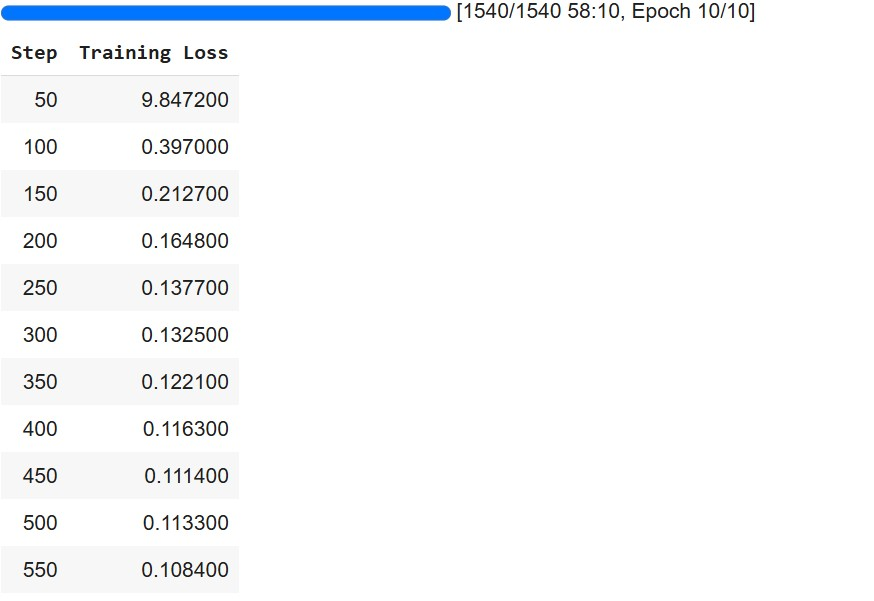

In [ ]:
index = 112
dialogue = dataset['test'][index]['dialogue']
baseline_human_summary = dataset['test'][index]['summary']

prompt = f"""
Summarize the following conversation.

{dialogue}

Summary: """

input_ids = tokenizer(prompt, return_tensors="pt").input_ids

original_model_outputs = original_model.generate(input_ids=input_ids.to(original_model.device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
original_model_text_output = tokenizer.decode(original_model_outputs[0], skip_special_tokens=True)

peft_model_outputs = peft_model.generate(input_ids=input_ids.to(original_model.device), generation_config=GenerationConfig(max_new_tokens=200, num_beams=1))
peft_model_text_output = tokenizer.decode(peft_model_outputs[0], skip_special_tokens=True)

print(f'PROMPT: \n {prompt}')
print()
print(f'BASELINE HUMAN SUMMARY:\n{baseline_human_summary}')
print()
print(f'ORIGINAL MODEL:\n{original_model_text_output}')
print()
print(f'PEFT MODEL:\n {peft_model_text_output}')

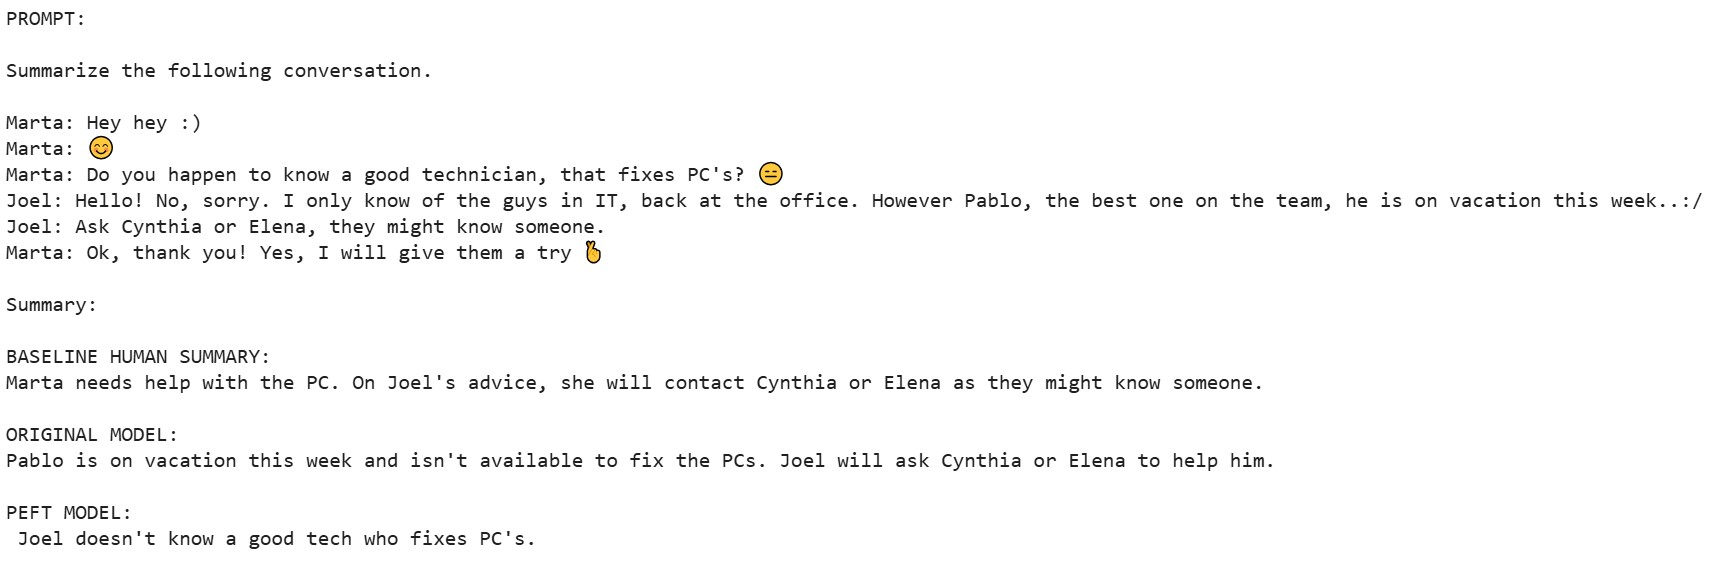